In [84]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")


## audio, labels, speech recognition

0 i ------------------- from 0.3000 to 0.4200 sec, confidence: 100.00%
1 skymningen ---------- from 0.4200 to 1.2600 sec, confidence: 100.00%
2 en ------------------ from 1.3500 to 1.5000 sec, confidence: 100.00%
3 mycket -------------- from 1.5000 to 1.8000 sec, confidence: 100.00%
4 het ----------------- from 1.8300 to 2.1000 sec, confidence: 100.00%
5 dag ----------------- from 2.1000 to 2.4300 sec, confidence: 100.00%
6 i ------------------- from 2.4300 to 2.5200 sec, confidence: 100.00%
7 början -------------- from 2.5200 to 2.7900 sec, confidence: 100.00%
8 av ------------------ from 2.7900 to 2.9100 sec, confidence: 100.00%
9 juli ---------------- from 2.9100 to 3.3600 sec, confidence: 100.00%
10 lämnade ------------- from 3.3600 to 3.9900 sec, confidence: 100.00%
11 en ------------------ from 3.9900 to 4.1400 sec, confidence: 100.00%
12 ung ----------------- from 4.1400 to 4.4100 sec, confidence: 100.00%
13 man ----------------- from 4.4100 to 4.6800 sec, confidence: 100.00%
14

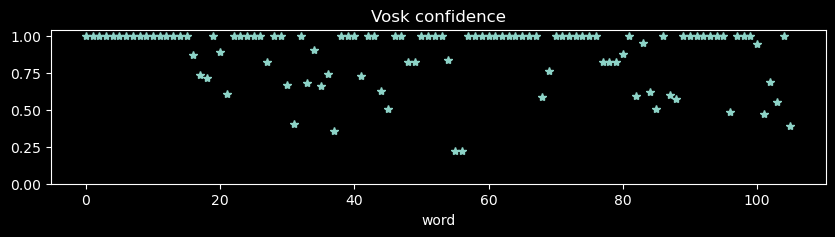

In [85]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"

if "model" not in locals():
    model = Model(model_path)

words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])

# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()


In [86]:
labels_path = (
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_praat"
)

labels_df = pd.read_csv(labels_path)
display(labels_df)


,tmin,tmax
0,0.560813,0.610813
1,0.634599,0.684599
2,0.700651,0.750651
3,0.841320,0.891320
4,0.905731,0.955731
...,...,...
170,42.950020,43.000020
171,43.119169,43.169169
172,43.310235,43.394727
173,43.557646,43.607646


In [87]:
reload(tools)
add_context = False
fl = int(0.02 * Fs)
grouped_frames = tools.julgran(words, audio, Fs, fl, add_context)

vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1


print("found vowels:")
for v in grouped_frames.keys():
    print(
        "    ",
        v,
        len(grouped_frames[v]["frame"]),
        str(round(100 * len(grouped_frames[v]["frame"]) / vowels_in_text[v], 3)) + "%",
    )

print("total: vowels in text", sum([vowels_in_text[v] for v in vowels_in_text.keys()]))
for v in vowels_in_text.keys():
    print(vowels_in_text[v])


found vowels:
     o 10 55.556%
     å 3 37.5%
     a 30 63.83%
     i 18 78.261%
     ä 6 85.714%
     u 7 70.0%
     ö 3 33.333%
     y 4 80.0%
     e 22 57.895%
total: vowels in text 165
18
8
47
23
7
10
9
5
38


In [88]:
len(grouped_frames["a"]["start"])

starts_all = []
for v in grouped_frames.keys():
    starts_all.extend(grouped_frames[v]["start"])
starts_all = np.array(starts_all)

print("total found vowels:", len(starts_all))
starts_all = np.sort(starts_all)
stops_all = starts_all + fl
starts_all_seconds = starts_all / Fs
stops_all_seconds = stops_all / Fs

print(starts_all_seconds)

print("unique start points:", len(np.unique(starts_all)))


total found vowels: 103
[ 0.4        0.72       1.02       1.24       1.47       1.58
  1.72       1.87       2.32       2.47       2.52       2.62
  2.89       3.07       3.21       3.42       3.68       3.86
  4.03       4.28       4.51       4.86       4.96       5.22
  5.52       6.56       8.06       8.15       8.33       8.57
  8.77       9.12       9.9878458 10.4078458 10.53      11.27
 11.55      11.75      11.95      14.28      14.48      14.64
 15.16      15.65      15.77      15.89      16.12      17.59
 17.75      18.12      19.21      19.34      19.46      19.78
 19.96      20.16      21.54      21.84      22.04      22.35
 23.        23.1       23.22      23.58      23.98      24.15
 24.51      24.62      25.08      27.25      27.39      27.61
 27.63      29.14      30.13      31.03      31.32      31.53
 31.63      31.87      32.3       32.46      33.81      34.03
 35.5324263 36.78      37.43      37.49      37.64      37.74
 38.1       38.34      38.7       39.04      3

In [89]:
display(labels_df.head(10))

,tmin,tmax
0,0.560813,0.610813
1,0.634599,0.684599
2,0.700651,0.750651
3,0.841320,0.891320
4,0.905731,0.955731
5,0.995099,1.045099
6,1.450720,1.500720
7,1.512625,1.562625
8,1.574162,1.624162
9,1.704862,1.754862


In [90]:
included = 0
for start, stop in zip(starts_all_seconds, stops_all_seconds):
    included += labels_df.apply(
        lambda x: (start - x.tmin) > 0 and (x.tmax - stop) > 0, axis=1
    ).sum()

print(included)
print("in right range", included / len(starts_all_seconds))


27
in right range 0.2621359223300971
